c:\Users\user\SIFA Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kenya loans: 75,825
Feature matrix: (75825, 72)
Class balance — Monthly: 61.0% | Other: 39.0%
Train: 60,660 | Test: 15,165
Best iteration: 499

────────────────────────────────────────
  🇰🇪 Sifa-Score v2.0 — Evaluation
────────────────────────────────────────
  Accuracy : 89.74%
  F1-Score : 91.84%
  ROC-AUC  : 0.9556
────────────────────────────────────────

Classification Report:
              precision    recall  f1-score   support

    Declined       0.91      0.82      0.86      5919
    Approved       0.89      0.95      0.92      9246

    accuracy                           0.90     15165
   macro avg       0.90      0.88      0.89     15165
weighted avg       0.90      0.90      0.90     15165

✅ Model and metadata saved to disk.


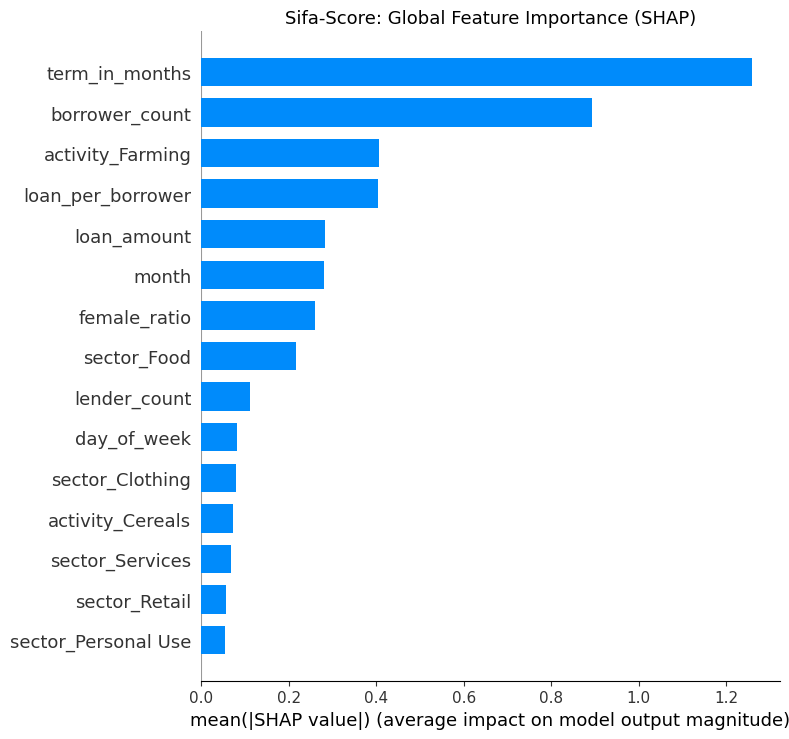


Loan Decision: ✅ Approved
Confidence:    93.0%


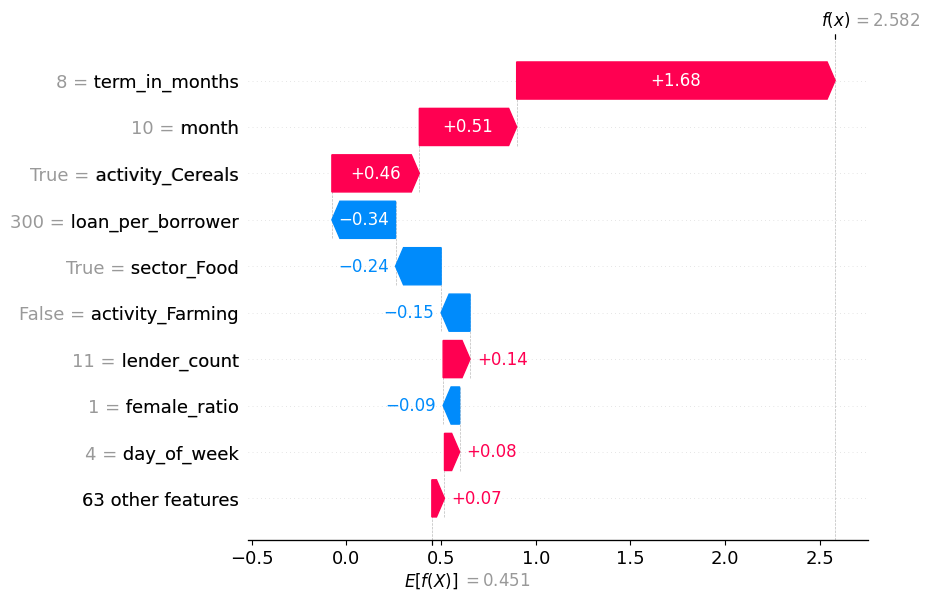

c:\Users\user\SIFA Project\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1



──────────────────────────────────────────────────
  📬 Sifa Advisory — APPROVED
──────────────────────────────────────────────────
Dear [Borrower],

We are thrilled to inform you that your loan application has been APPROVED! Our AI model at Sifa-Score has carefully reviewed your request and is pleased to confirm that your proposal meets our lending criteria.

As we analyzed your application, we were impressed by the strength of your SHAP evidence. The term in months demonstrated a significant impact on your business plan, showcasing a clear understanding of how you intend to utilize the loan. Your activity in cereals also stood out, highlighting a consistent track record of success in this area. Moreover, the month-to-month fluctuations showed a remarkable resilience in the face of market uncertainties.

Your strong application was built upon a solid foundation of financial planning and a deep understanding of your industry. We are confident that with our loan, you will be able to tak

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════
# SIFA-SCORE AI — Improved Training Pipeline
# Author: Derick Gikonyo | February 2026
# ═══════════════════════════════════════════════════════════════════════════════
#
# Changes from v1:
#   • Model persisted to disk (joblib) — no retraining on every dashboard load
#   • Full evaluation: accuracy, F1, ROC-AUC, classification report
#   • Global SHAP summary plot (not just single-loan waterfall)
#   • Fixed LLM prompt (removed placeholder text, typo fixes, Kenyan context)
#   • Target variable caveat documented
# ═══════════════════════════════════════════════════════════════════════════════

# ── CELL 1: Imports ────────────────────────────────────────────────────────────
import joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report
)

# ── CELL 2: Load & Filter ─────────────────────────────────────────────────────
df      = pd.read_csv('kiva_loans.csv')
df_k    = df[df['country'] == 'Kenya'].copy()
print(f"Kenya loans: {len(df_k):,}")

# ── CELL 3: Feature Engineering ───────────────────────────────────────────────
def parse_gender(s):
    """Returns (borrower_count, female_ratio) from a gender string."""
    if pd.isna(s) or str(s).strip() == '':
        return 1, 0.5
    parts = [g.strip().lower() for g in str(s).split(',')]
    n     = len(parts)
    f     = sum(1 for g in parts if 'female' in g)
    return n, f / n


def engineer_features(df, top_activities=None):
    d = df.copy()

    # Gender signals
    gs = d['borrower_genders'].apply(parse_gender)
    d['borrower_count'] = gs.apply(lambda x: x[0])
    d['female_ratio']   = gs.apply(lambda x: x[1])

    # Economic density
    d['loan_per_borrower'] = d['loan_amount'] / d['borrower_count'].clip(lower=1)

    # Seasonal features
    d['posted_time'] = pd.to_datetime(d['posted_time'], errors='coerce')
    d['month']       = d['posted_time'].dt.month.fillna(6).astype(int)
    d['day_of_week'] = d['posted_time'].dt.dayofweek.fillna(0).astype(int)

    # Cardinality control — keep top 50 activities
    if top_activities is None:
        top_activities = d['activity'].value_counts().head(50).index.tolist()
    d['activity'] = d['activity'].apply(
        lambda x: x if x in top_activities else 'Other'
    )

    cols = ['loan_amount', 'term_in_months', 'lender_count',
            'borrower_count', 'female_ratio', 'loan_per_borrower',
            'month', 'day_of_week', 'sector', 'activity']

    X = pd.get_dummies(d[cols], drop_first=True)
    return X, top_activities


X, top_acts = engineer_features(df_k)
print(f"Feature matrix: {X.shape}")

# ── CELL 4: Target Variable ───────────────────────────────────────────────────
# ⚠️  IMPORTANT CAVEAT
# -----------------------------------------------------------
# We use repayment_interval == 'monthly' as a proxy for low-risk loans.
# This captures structured, predictable repayment behaviour — but it is
# NOT a true default label. The model therefore predicts repayment structure,
# not default probability.
#
# RECOMMENDED UPGRADE: If your dataset contains a 'status' column with
# values like 'paid' / 'defaulted', replace the line below with:
#
#   y = df_k['status'].apply(lambda x: 0 if x == 'defaulted' else 1)
#
# That would make this a genuine credit risk model.
# -----------------------------------------------------------
y = df_k['repayment_interval'].apply(lambda x: 1 if x == 'monthly' else 0)
print(f"Class balance — Monthly: {y.mean():.1%} | Other: {1 - y.mean():.1%}")

# ── CELL 5: Stratified Train/Test Split ───────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

# ── CELL 6: Train XGBoost with Early Stopping ─────────────────────────────────
model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    early_stopping_rounds=50,
    tree_method='hist',
    eval_metric='logloss',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print(f"Best iteration: {model.best_iteration}")

# ── CELL 7: Full Evaluation (not just accuracy) ────────────────────────────────
preds  = model.predict(X_test)
probas = model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, preds)
f1   = f1_score(y_test, preds)
auc  = roc_auc_score(y_test, probas)

print(f"\n{'─'*40}")
print(f"  🇰🇪 Sifa-Score v2.0 — Evaluation")
print(f"{'─'*40}")
print(f"  Accuracy : {acc*100:.2f}%")
print(f"  F1-Score : {f1*100:.2f}%")
print(f"  ROC-AUC  : {auc:.4f}")
print(f"{'─'*40}")
print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=['Declined', 'Approved']))

# ── CELL 8: Save Model & Metadata to Disk ─────────────────────────────────────
# This means the dashboard loads instantly — no retraining on every run.
metrics = {
    'accuracy': acc, 'f1': f1, 'auc': auc,
    'train_size': len(X_train), 'test_size': len(X_test),
    'report': classification_report(y_test, preds,
                                    target_names=['Declined', 'Approved'],
                                    output_dict=True)
}

meta = {
    'X_full':         X,
    'X_test':         X_test,
    'y_test':         y_test,
    'top_activities': top_acts,
    'metrics':        metrics,
    'column_order':   X.columns.tolist()
}

joblib.dump(model, 'sifa_model.joblib')
joblib.dump(meta,  'sifa_meta.joblib')
print("✅ Model and metadata saved to disk.")

# ── CELL 9: Global SHAP — Feature Importance ──────────────────────────────────
explainer  = shap.Explainer(model)
X_sample   = X_test.sample(200, random_state=42)
sv_global  = explainer(X_sample)

plt.figure(figsize=(10, 7))
shap.summary_plot(sv_global, X_sample, plot_type="bar",
                  max_display=15, show=False)
plt.title("Sifa-Score: Global Feature Importance (SHAP)", fontsize=13)
plt.tight_layout()
plt.savefig("shap_global.png", dpi=150)
plt.show()

# ── CELL 10: Single Loan — Waterfall Plot ─────────────────────────────────────
sample_loan = X_test.iloc[0:1]
sv_single   = explainer(sample_loan)

pred   = model.predict(sample_loan)[0]
prob   = model.predict_proba(sample_loan)[0, 1]
status = "✅ Approved" if pred == 1 else "❌ Declined"

print(f"\nLoan Decision: {status}")
print(f"Confidence:    {prob:.1%}")

shap.plots.waterfall(sv_single[0])

# ── CELL 11: LLM Advisory — Improved Prompt ───────────────────────────────────
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate

feature_names = X_test.columns
shap_df = pd.DataFrame({
    'feature':      feature_names,
    'contribution': sv_single.values[0]
})

if pred == 1:
    top_factors = shap_df.nlargest(3, 'contribution')
    tone        = "warm, celebratory, and professional"
else:
    top_factors = shap_df.nsmallest(3, 'contribution')
    tone        = "empathetic, advisory, and constructive"

evidence = "\n".join([
    f"- {row['feature'].replace('_', ' ').title()}: "
    f"SHAP impact {row['contribution']:+.4f}"
    for _, row in top_factors.iterrows()
])

decision = "Approved" if pred == 1 else "Declined"

TEMPLATE = """
You are a Senior Loan Officer at Sifa-Score in Nairobi, Kenya.
The AI model has {status} this loan application.

SHAP Evidence:
{evidence}

Instructions:
- Write a {tone} letter to the borrower.
- Reference the specific SHAP factors above naturally — weave them into the
  narrative, do not just list them.
- For approvals: explain what made this a strong application and outline next steps.
- For declines: provide one concrete, actionable improvement tip per risk factor,
  grounded in Kenyan context (e.g. M-Pesa repayment cycles, chama group savings,
  agricultural seasons, market days).
- Address the borrower directly. Do NOT use placeholder text like "[Name]".
- Length: 200–280 words. Professional but warm.
- End with: "Sifa-Score Team, Nairobi."
"""

llm    = ChatOllama(model="llama3", temperature=0.3)
prompt = ChatPromptTemplate.from_template(TEMPLATE)
chain  = prompt | llm

print(f"\n{'─'*50}")
print(f"  📬 Sifa Advisory — {decision.upper()}")
print(f"{'─'*50}")

response = chain.invoke({
    "status":   decision,
    "evidence": evidence,
    "tone":     tone
})
print(response.content)